# Imports

In [1]:
import warnings
import os
import glob
import pickle
import torch
import lightning.pytorch as pl
import numpy as np
import sys
from argparse import ArgumentParser
from collections import defaultdict
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from lightning.pytorch.tuner import Tuner


In [2]:
# UNIX
working_dir = "/Users/andry/Documents/GitHub/lus-dl-framework"
dataset_h5_path = "data/iclus/dataset.h5"
hospitaldict_path = "data/iclus/hospitals-patients-dict.pkl"

# Windows
# working_dir = "../."
# dataset_h5_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5"
# hospitaldict_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl"
libraries_dir = working_dir + "/libraries"


sys.path.append(working_dir)
os.chdir(working_dir)
os.getcwd()

from utils import *
from callbacks import *
from run_model import *
from get_sets import get_sets, get_class_weights

import sys
sys.path.append(working_dir)
from data_setup import HDF5Dataset, FrameTargetDataset, split_dataset, reduce_sets
from lightning_modules.LUSModelLightningModule import LUSModelLightningModule
from lightning_modules.LUSDataModule import LUSDataModule


# Args

In [3]:
from argparse import ArgumentParser
import json
import sys

# ------------------------------ Parse arguments ----------------------------- #
def parse_arguments(args=None):
    if args is None:
        # If no arguments are provided, use the command-line arguments of the notebook
        args = sys.argv[1:]

    # Parse command-line arguments
    parser = ArgumentParser()

    allowed_models = ["google_vit", 
                    "resnet18",
                    "resnet10",
                    "resnet50",
                    "beit", 
                    'timm_bot', 
                    "botnet18", 
                    "botnet50",
                    "vit",
                    "swin_vit",
                    "simple_vit"]

    allowed_modes = ["train", "test", "train_test", "tune"]
    parser.add_argument("--model", type=str, choices=allowed_models)
    parser.add_argument("--mode", type=str, choices=allowed_modes)
    parser.add_argument("--version", type=str)
    parser.add_argument("--working_dir_path", type=str)
    parser.add_argument("--dataset_h5_path", type=str)
    parser.add_argument("--hospitaldict_path", type=str)
    
    parser.add_argument("--trim_data", type=float)
    parser.add_argument("--trim_train", type=float)
    parser.add_argument("--trim_test", type=float)
    parser.add_argument("--trim_val", type=float)
    
    parser.add_argument('--ratios', nargs='+', type=float, help='Sets ratios')


    parser.add_argument("--chkp", type=str)
    parser.add_argument("--rseed", type=int)
    parser.add_argument("--train_ratio", type=float)
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--optimizer", type=str, default="sgd")
    parser.add_argument("--lr", type=float, default=0.001)
    parser.add_argument("--weight_decay", type=float, default=0.001)
    parser.add_argument("--momentum", type=float, default=0.001)
    parser.add_argument("--label_smoothing", type=float, default=0.1)
    parser.add_argument("--drop_rate", type=float, default=0.1)
    parser.add_argument("--max_epochs", type=int, default=1)
    parser.add_argument("--num_workers", type=int, default=4)
    parser.add_argument("--accumulate_grad_batches", type=int, default=4)
    parser.add_argument("--precision", default=32)
    parser.add_argument("--disable_warnings", dest="disable_warnings", action='store_true')
    parser.add_argument("--pretrained", dest="pretrained", action='store_true')
    parser.add_argument("--freeze_layers", type=str)
    parser.add_argument("--test", dest="test", action='store_true')
    parser.add_argument("--mixup", dest="mixup", action='store_true')
    parser.add_argument("--augmentation", dest="augmentation", action='store_true')
    parser.add_argument("--summary", dest="summary", action='store_true')
    

    # Add an argument for the configuration file
    parser.add_argument('--config', type=str, help='Path to JSON configuration file')

    args = parser.parse_args(args)

    # -------------------------------- json config ------------------------------- #

    config_path = 'configs/configs.json'
    selected_config = None
    # If a configuration file was provided, load it
    if args.config:
        with open(config_path, 'r') as f:
            configurations = json.load(f)
        for config in configurations:
            if config['config'] == args.config:
                selected_config = config
                break

        # Override the command-line arguments with the configuration file
        for key, value in selected_config.items():
            if hasattr(args, key):
                setattr(args, key, value)
                
        # Check and set the ratios
        if "ratios" in selected_config:
            ratios = selected_config["ratios"]
            if len(ratios) != 3 or sum(ratios) != 1:
                parser.error('Invalid ratios provided in the configuration file')
            
        
    print(f"args are: {args}")

    return args


In [4]:
args_list = ['--model', 'swin_vit', 
             '--mode', 'train', 
             '--batch_size', '32',
             '--dataset_h5_path', f'{dataset_h5_path}',
             '--hospitaldict_path', f'{hospitaldict_path}',
             '--working_dir_path', f'{working_dir}',
             '--ratios', '0.6', '0.2', '0.2',
             '--rseed', '42',
             '--optimizer', 'adamw',
             '--lr', '0.001',
             '--weight_decay', '0.001',
             '--momentum', '0.9',
             '--label_smoothing', '0.1',
             '--drop_rate', '0.2',
             '--max_epochs', '10',
             '--num_workers', '0',
             '--accumulate_grad_batches', '1',
             '--precision', '32',
             '--disable_warnings',
            #  '--mixup',
             '--augmentation',
             '--summary',
            #  '--pretrained',
            #  '--freeze_layers', '0',
             
             ]

In [5]:
args = parse_arguments(args_list)

args are: Namespace(model='swin_vit', mode='train', version=None, working_dir_path='/Users/andry/Documents/GitHub/lus-dl-framework', dataset_h5_path='data/iclus/dataset.h5', hospitaldict_path='data/iclus/hospitals-patients-dict.pkl', trim_data=None, trim_train=None, trim_test=None, trim_val=None, ratios=[0.6, 0.2, 0.2], chkp=None, rseed=42, train_ratio=None, batch_size=32, optimizer='adamw', lr=0.001, weight_decay=0.001, momentum=0.9, label_smoothing=0.1, drop_rate=0.2, max_epochs=10, num_workers=0, accumulate_grad_batches=1, precision='32', disable_warnings=True, pretrained=False, freeze_layers=None, test=False, mixup=False, augmentation=True, summary=True, config=None)


In [6]:
import warnings

pl.seed_everything(args.rseed)
if args.disable_warnings: 
    print("Warnings are DISABLED!\n\n")
    warnings.filterwarnings("ignore")
else:
    warnings.filterwarnings("default")

Global seed set to 42


Warnings are DISABLED!




# Get Datasets

In [7]:
sets, split_info = get_sets(args)
lus_data_module = LUSDataModule(sets["train"], 
                                sets["test"],
                                sets["val"],
                                args.num_workers, 
                                args.batch_size,
                                args.mixup)


image_mean: [0.12516, 0.12867, 0.13234]
image_std: [0.16526, 0.16911, 0.1752]

Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.
Split ratios: [0.6, 0.2, 0.2]

Serialized splits found, loading ...

Train size: 33854, Test size: 12486, Val size: 12584

Transforms:
TrainPreprocess()


Transforms:
Preprocess()


Transforms:
Preprocess()

Train size: 33854
Test size: 12486
Validation size: 12584


In [8]:
# weight_tensor = get_class_weights((sets["train_indices"] + sets["val_indices"]), split_info)

# Plot the distributions

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def plot_class_distribution(indices_set, split_info):
    set_labels = [split_info['labels'][index] for index in indices_set]

    # Ensure class labels are unique and sorted
    unique_sorted_labels = sorted(set(set_labels))

    # Count occurrences of each class, preserving the order of sorted unique labels
    class_counts = {label: set_labels.count(label) for label in unique_sorted_labels}
    
    # Define custom colors for each class
    custom_colors = {
        0: '#adde92',    # Example color for class 0
        1: '#ffbd78',   # Example color for class 1
        2: '#ff9b9a',  # Example color for class 2
        3: '#f41d25'  # Example color for class 3
    }
    # Map the class labels to their custom colors
    bar_colors = [custom_colors[label] for label in class_counts.keys()]

    # Set font size and family
    plt.rcParams.update({'font.size': 14, 'font.family': 'Roboto'})

    plt.figure(figsize=(8, 6), facecolor='white')
    plt.bar(range(len(class_counts)), list(class_counts.values()), color=bar_colors, tick_label=list(class_counts.keys()), width=0.75)
    plt.title('Class Distribution in the Set')

    plt.show()


### Train distribution

findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not

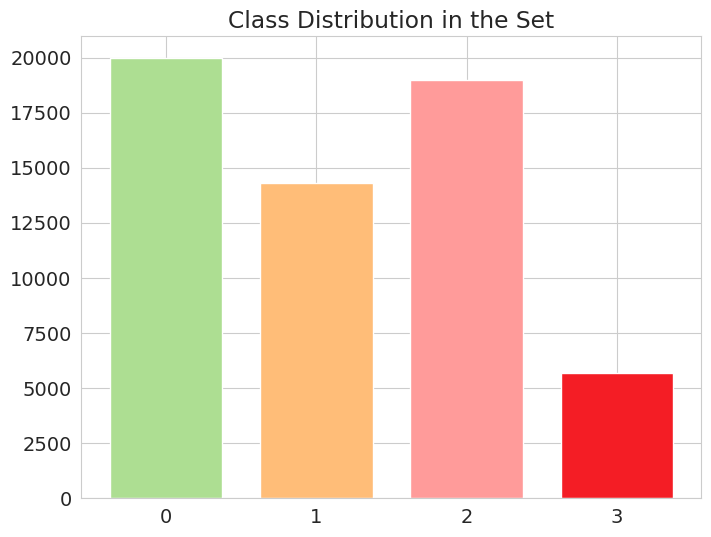

In [53]:
plot_class_distribution(sets["train_indices"]+sets["val_indices"]+sets["test_indices"], split_info)

### Val distribution

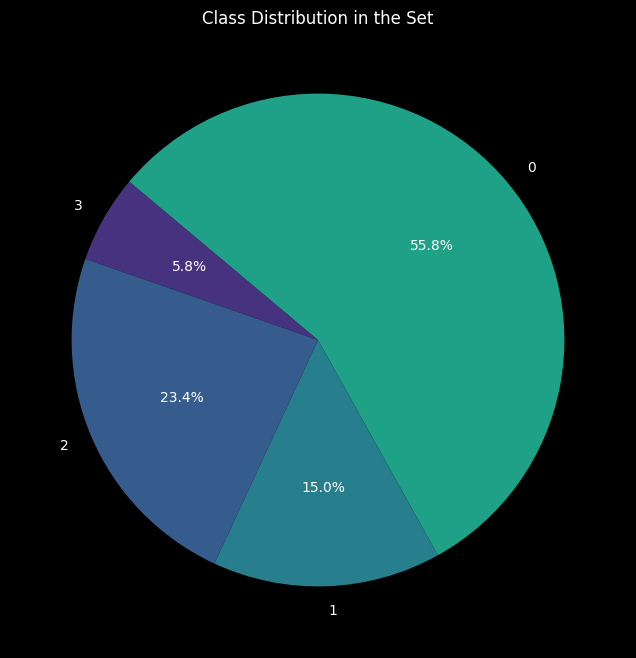

In [11]:
plot_class_distribution(sets["val_indices"], split_info)

### Test distribution

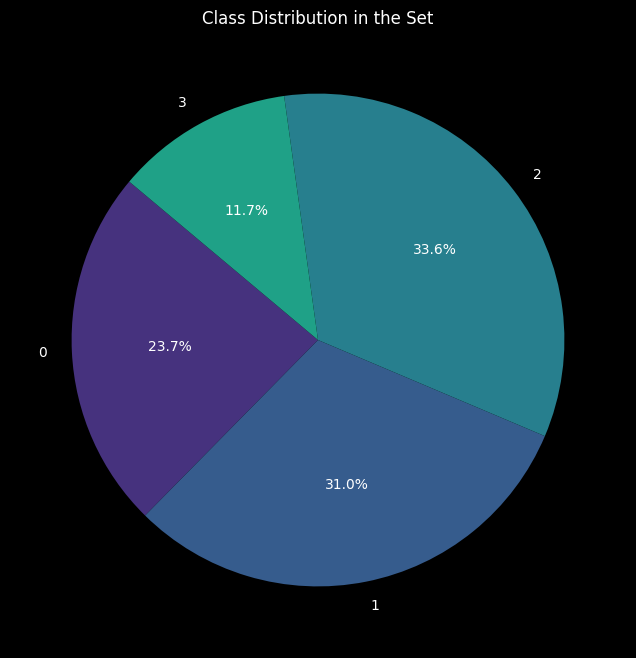

In [12]:
plot_class_distribution(sets["test_indices"], split_info)